### Import Libraries

In [1]:
import gym
import utils
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

### Create Bandit class as environment

In [2]:
# Here the default setting is to have 2 arms,
# first one having a probability of winning 0.5 and reward 1, and 
# the second one having probability of winning 0.1 and reward 100

DEFAULT_BANDIT = [(0.5,1), (0.10,100)]

class KBandit:
  
  def __init__(self, k= None):
    """
      input:
        k list of tuples each tuple like (win propability, score)
      returns:
        K armed bandit based on input tuple
    """
    if k is None: k = DEFAULT_BANDIT
    self.k = k
    self.actions = range(len(k))

  def step(self, action):
    """
      input:
        pulls lever with number action
      returns:
        reward from lever pull
    """
    win_p, score = self.k[action]
    return np.random.choice(a = [0,score], size=1, p=[1-win_p,win_p])


If we create a Bandit object with default setting and pull either arm to see results

In [3]:
B = KBandit()
print('Pulling first arm 10 times')
# This gives us a reward of 1 roughly half of the times
for i in range(10):
    print(B.step(0),end='')

print('\n\nPulling second arm 10 times')
# This gives us a reward of 100 roughly 1/10 of the times
for i in range(10):
    print(B.step(1),end='')

Pulling first arm 10 times
[0][1][1][1][1][0][0][0][1][1]

Pulling second arm 10 times
[0][0][100][100][0][0][0][0][0][0]

### The pseudo code for simple Epsilon-Greedy bandit algorithm is shown below

![cliffworld](https://drive.google.com/uc?id=1qg4bZPVvs88CARX353b2kzvxoCtv9Gzy)

### Implement Epsilon-Greedy algorithm

In [4]:
class Epsilon_greedy:
  
  def __init__(self, epsilon):
    self.epsilon = epsilon
    self.q = None
    self.n = None
    
  def set_epsilon(self, epsilon):
    self.epsilon = epsilon

  def _init_model(self, env):
    num_actions = len(env.actions)
    self.q = np.array([0.0]*num_actions)
    self.n = np.array([0.0]*num_actions)
    
  def select_action(self):
    if self.epsilon > np.random.uniform(size=1)[0]:
      return self.random_action()
    else:
      return self.greedy_action()
  
  def random_action(self):
    return np.random.choice(range(len(self.q)))
  
  def greedy_action(self):
    best_actions = np.where(max(self.q)==self.q)[0]
    return np.random.choice(best_actions)

  def update(self, action, reward):
    self.n[action] += 1
    self.q[action] +=  1/self.n[action]*(reward - self.q[action])
  
  def train(self, env, num_epochs= 1000, force_init=False):
    print('Training the algorithm')
    if self.q is None or force_init or self.n is None:
      self._init_model(env)
   
    for i in range(num_epochs):
      action = self.select_action()
      reward = env.step(action)
      self.update(action, reward)

### Perform Epsilon-Greedy on Bandit

In [5]:
# Create a Bandit object
bandit_env = KBandit()

# Create an epsilon-greedy object
e_greedy = Epsilon_greedy(0.05)

# Train the algorithm
e_greedy.train(bandit_env, num_epochs=10000)

# Results
print('Number of times arms pulled',e_greedy.n)
print('Estimated rewards', e_greedy.q)

Training the algorithm
Number of times arms pulled [ 315. 9685.]
Estimated rewards [ 0.5047619  10.57305111]


If we train for large number of epochs, we can see the rewards converging 0.5 and 10

# Forzen lake Dynamic programming

    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following
        SFFF
        FHFH
        FFFH
        HFFG
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

In [6]:
# Create a frozen lake environment from GYM
env = gym.make("FrozenLake-v0").env

In [7]:
# Test run of frozen lake

observation = env.reset()

while True:    
    #your agent goes here
    action = env.action_space.sample() 
         
    observation, reward, done, info = env.step(action) 
   
    env.render()
    if done: 
      break;
            
env.close()

  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


# Pseudo code for Value Iteration Algorithm

![cliffworld](https://drive.google.com/uc?id=1CKukd0rhRMCRm1HEWAony42jGV1HoydO)

In [8]:
# Create Class for Value Iteration Using Dynamic Programming

class DP_value_iteration:
  
  def __init__(self, theta=0.001, discount_factor=0.9):
    self.theta = theta
    self.df = discount_factor
    self.V = None
    self.P = None
    
  def _get_greedy_policy_from_V(self, env):
    # Create a deterministic policy using the optimal value function
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        # One step lookahead to find the best action for this state
        A = self._one_step_lookahead(env, s)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0
    
    self.P = policy
    
  def _one_step_lookahead(self, env, state):
    A = np.zeros(env.nA)
    for a in range(env.nA):
        for prob, next_state, reward, done in env.P[state][a]:
            A[a] += prob * (reward + self.df * self.V[next_state])
    return A
  
  def _get_delta(self, best_action_value, s):
    return np.abs(best_action_value - self.V[s])
  
  def _init_model(self, env):
    self.V = np.zeros(env.nS)
    
  def train(self, env, force_init=False):
    if self.V is None or roce_init:
      self._init_model(env)
    
    while True:
      delta = 0
      # Update each state...
      for s in range(env.nS):
          # Do a one-step lookahead to find the best action
          A = self._one_step_lookahead(env, s)
          best_action_value = np.max(A)
          # Calculate delta across all states seen so far
          delta = max(delta, np.abs(best_action_value - self.V[s]))
          # Update the value function. Ref: Sutton book eq. 4.10. 
          self.V[s] = best_action_value
      if delta < self.theta:
        break
          
    self._get_greedy_policy_from_V(env)

In [9]:
# Perform the Dynamic Programming Value Iteration on Frozen Lake Environment

env = gym.make("FrozenLake-v0", is_slippery=False).env

dp_agent = DP_value_iteration()

dp_agent.train(env)

### Value function and Policy After Learning

In [10]:
print('Game world start')
env.render()
print()
policy, v = dp_agent.P, dp_agent.V

print("Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):")
print(np.reshape(np.argmax(policy, axis=1), (env.nA, env.nA)))
print("")

print("Reshaped Grid Value Function:")
print(v.reshape((env.nA, env.nA)))


Game world start

SFFF
FHFH
FFFH
HFFG

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]

Reshaped Grid Value Function:
[[0.59049 0.6561  0.729   0.6561 ]
 [0.6561  0.      0.81    0.     ]
 [0.729   0.81    0.9     0.     ]
 [0.      0.9     1.      0.     ]]


# Pseudo -Code for Monte Carlo Algorithm

![cliffworld](https://drive.google.com/uc?id=1lZRPjVflaigujbzg9CLX2wCD-K2-eAmW)

In [11]:
import sys
from collections import defaultdict

# First create random and greedy policy

class Random_policy:
  
  def __init__(self, num_actions):
    self.A = np.ones(num_actions, dtype=float) / num_actions
  
  def get_policy_for_state(self, s):
    return self.A
  
class Greedy_policy():
  
  def __init__(self, Q):
    self.Q = Q
  
  def set_Q(self, Q):
    self.Q = Q
    
  def get_policy_for_state(self, s):
    A = np.zeros_like(self.Q[s], dtype=float)
    best_action = np.argmax(self.Q[s])
    A[best_action] = 1.0
    return A
  

class Episode_generator():
  
  def __init__(self, agent, env):
    self.agent = agent
    self.env = env

  def create_episode(self):
    episode = []
    state = self.env.reset()
    for t in range(100):
      # Sample an action from our policy
      probs = self.agent.get_policy_for_state(state)
      action = np.random.choice(np.arange(len(probs)), p=probs)
      next_state, reward, done, _ = self.env.step(action)
      episode.append((state, action, reward))
      if done:
          break
      state = next_state
    return episode

        
class MC_controll_importance_sampling:
  
  
  def __init__(self, num_episodes = 100000, verbose=False, discount_factor=0.9):
    self.verbose = verbose
    self.nE = num_episodes
    self.tp = None
    self.df=discount_factor
    self.Q = None
    self.C = None
    
  def _init_model(self, env):
    self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
    self.C = defaultdict(lambda: np.zeros(env.action_space.n))
    self.tp = Greedy_policy(self.Q.copy())
    
    self.behavorial_agent = Random_policy(env.action_space.n)
    self.episode_gen = Episode_generator(self.behavorial_agent, env)
    
    
  def _update(self, episode):
    G = 0.0
    W = 1.0
    # for each step in episode backwards
    for t in range(len(episode))[::-1]:
      state, action, reward = episode[t]
      G = self.df * G + reward
      self.C[state][action] += W
      self.Q[state][action] += (W / self.C[state][action]) * (G - self.Q[state][action])
      self.tp.set_Q(self.Q.copy())
      
      if action !=  np.argmax(self.tp.get_policy_for_state(state)):
        break
        
      W = W * 1./self.behavorial_agent.get_policy_for_state(state)[action]
      
  def train(self, env, force_init=False):
    
    if self.Q is None or self.C is None or force_init:
      self._init_model(env)
    
    
    for i_episode in tqdm(range(1, self.nE + 1)):

      if i_episode % 10000 == 0 and self.verbose:
          print("Episode %i" % (i_episode))
          sys.stdout.flush()

      episode = self.episode_gen.create_episode()
      self._update(episode)

In [12]:
# Create Frozen Lake Environment
env = gym.make("FrozenLake-v0", is_slippery=False).env

# Initialize Monte Carlo Importance Sampling Object
mc_ctrl = MC_controll_importance_sampling()

mc_ctrl._init_model(env)

# Train with MC algorithm
mc_ctrl.train(env)

100%|██████████| 100000/100000 [00:42<00:00, 2367.84it/s]


### Grid Policy After MC Learning 

In [13]:
policy = [mc_ctrl.tp.get_policy_for_state(s) for s in range(env.nS)]

print('Game world start')
env.reset()
env.render()

print("Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):")
print(np.reshape(np.argmax(policy, axis=1), (env.nA, env.nA)))
print("")

Game world start

SFFF
FHFH
FFFH
HFFG
Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]



In [14]:
env = gym.make("FrozenLake-v0", is_slippery=True).env


mc_ctrl = MC_controll_importance_sampling(verbose = True)

mc_ctrl._init_model(env)

mc_ctrl.train(env)


policy = [mc_ctrl.tp.get_policy_for_state(s) for s in range(env.nS)]


print('Game world start')
env.reset()
env.render()


print("Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):")
print(np.reshape(np.argmax(policy, axis=1), (env.nA, env.nA)))
print("")

 10%|▉         | 9982/100000 [00:04<00:36, 2463.49it/s]

Episode 10000


 20%|█▉        | 19831/100000 [00:08<00:32, 2486.10it/s]

Episode 20000


 30%|██▉       | 29973/100000 [00:12<00:28, 2437.13it/s]

Episode 30000


 40%|███▉      | 39834/100000 [00:16<00:25, 2389.69it/s]

Episode 40000


 50%|████▉     | 49892/100000 [00:21<00:20, 2473.82it/s]

Episode 50000


 60%|█████▉    | 59916/100000 [00:25<00:16, 2382.71it/s]

Episode 60000


 70%|██████▉   | 69910/100000 [00:29<00:12, 2444.25it/s]

Episode 70000


 80%|███████▉  | 79758/100000 [00:33<00:08, 2386.11it/s]

Episode 80000


 90%|████████▉ | 89764/100000 [00:37<00:04, 2381.34it/s]

Episode 90000


100%|█████████▉| 99793/100000 [00:42<00:00, 2376.07it/s]

Episode 100000


100%|██████████| 100000/100000 [00:42<00:00, 2365.15it/s]

Game world start

SFFF
FHFH
FFFH
HFFG
Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[3 3 1 1]
 [0 0 0 0]
 [0 0 1 0]
 [0 2 1 0]]



In [15]:
# Try the MC algorithm on another learning task
env = gym.make("Blackjack-v0")

mc_ctrl = MC_controll_importance_sampling(verbose = False)

mc_ctrl._init_model(env)

mc_ctrl.train(env)

100%|██████████| 100000/100000 [00:25<00:00, 3929.56it/s]


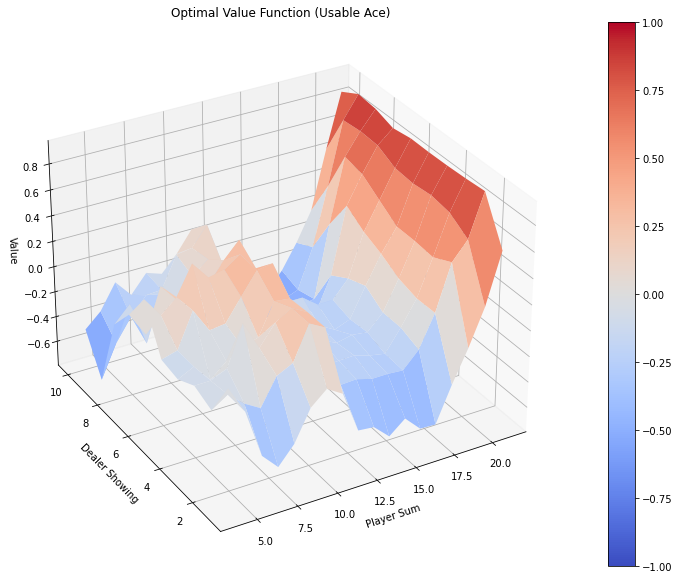

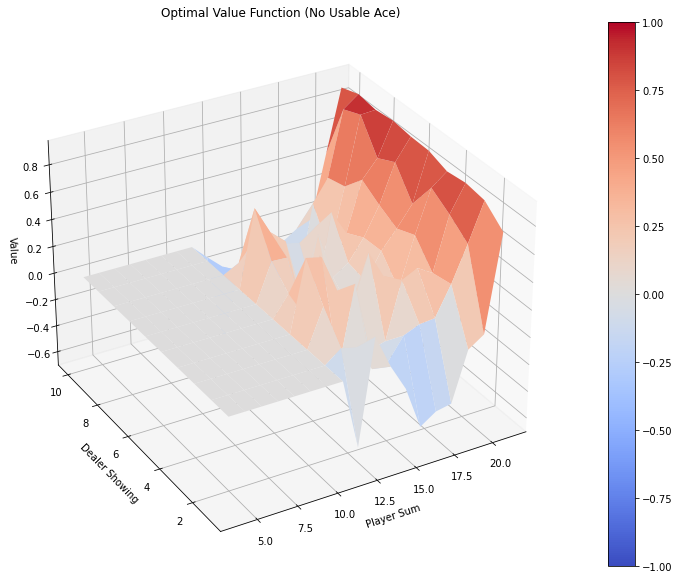

In [16]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in mc_ctrl.Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
utils.plot_value_function(V, title="Optimal Value Function")

# Q-Learning

# Cliff walking


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.
    Adapted from Example 6.6 (page 106) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://incompleteideas.net/book/bookdraft2018jan1.pdf
    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py
    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center
    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
    
  ![cliffworld](https://drive.google.com/uc?id=1FbykOcXgrhxbz7goBhQWztR6apQ2gPUV)

# Pseudo-Code for Q-learning Algorithm

![cliffworld](https://drive.google.com/uc?id=1U0KWkrCGIZ0AenGyorNGlAN88Yp8us-N)

# Create Q-learning Code

In [17]:
import itertools

class Greedy_policy():
  
  def __init__(self, Q):
    self.Q = Q
  
  def set_Q(self, Q):
    self.Q = Q
    
  def get_policy_for_state(self, s):
    A = np.zeros_like(self.Q[s], dtype=float)
    best_action = np.argmax(self.Q[s])
    A[best_action] = 1.0
    return A
  
class Epsilon_greedy_policy(Greedy_policy):
  
  def __init__(self, Q, epsilon):
    super(Epsilon_greedy_policy, self).__init__(Q)
    self.epsilon = epsilon
      
  def get_policy_for_state(self, s):
    greedy_policy = super(Epsilon_greedy_policy, self).get_policy_for_state(s)
    return self.make_greedy_policy_epsilon_greedy(greedy_policy)

  def make_greedy_policy_epsilon_greedy(self, greedy_pol):
    best_action = np.argmax(greedy_pol)
    greedy_pol += self.epsilon/len(greedy_pol)
    greedy_pol[best_action] -= self.epsilon
    return greedy_pol


    
class Q_Learning:
  
  
  def __init__(self, 
               num_episodes = 10000, 
               verbose=False, 
               discount_factor=0.9, 
               alpha=0.5, 
               epsilon=0.1):
    
    self.verbose = verbose
    self.nE = num_episodes
    self.df=discount_factor
    self.alpha=alpha
    self.epsilon=epsilon
      
    self.greedy_pol = None
    self.Q = None
    
  def _init_model(self, env):
    self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
    self.greedy_pol = Epsilon_greedy_policy(self.Q.copy(), self.epsilon)
    
  def _td_update(self, state, action, env):
    next_state, reward, done, _ = env.step(action)
    best_next_action = np.argmax(self.Q[next_state])
    td_target = reward + self.df * self.Q[next_state][best_next_action]
    td_delta = td_target - self.Q[state][action]
    self.Q[state][action] += self.alpha * td_delta
    self.greedy_pol.set_Q(self.Q.copy())
    return done, next_state
    
  def run_episode(self, env):
    
    state = env.reset()
    
    for t in itertools.count():
            
      # Take a step
      action_probs = self.greedy_pol.get_policy_for_state(state)
      action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

      done, next_state = self._td_update(state, action, env)

      if done or t == 50:
          break

      state = next_state
            
      
  def train(self, env, force_init=False):
    
    if self.Q is None or self.C is None or force_init:
      self._init_model(env)
    
    
    
    for i_episode in range(1, self.nE + 1):

      if i_episode % 10 == 0 and self.verbose:
          print("Episode %i" % (i_episode))
          sys.stdout.flush()
      
      self.run_episode(env)
      

In [18]:
from gym.envs.toy_text.cliffwalking import CliffWalkingEnv

env = CliffWalkingEnv()
q_learner = Q_Learning(num_episodes=100)
q_learner.train(env)

env.render()
world = np.zeros(env.shape)
for s, v in q_learner.Q.items():
  pos = np.unravel_index(s, env.shape)
  world[pos] = np.argmax(v)
# UP:0, RIGHT: 1, DOWN: 2, LEFT: 3
world

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x



array([[0., 1., 1., 2., 2., 2., 1., 1., 1., 1., 1., 2.],
       [0., 1., 1., 1., 1., 2., 1., 1., 1., 2., 2., 2.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [19]:
env = CliffWalkingEnv()
q_learner = Q_Learning(num_episodes=100)
q_learner.train(env)

In [20]:
env.render()
world = np.zeros(env.shape)
for s, v in q_learner.Q.items():
  pos = np.unravel_index(s, env.shape)
  world[pos] = np.argmax(v)
# UP:0, RIGHT: 1, DOWN: 2, LEFT: 3
world

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x



array([[1., 3., 0., 1., 1., 1., 1., 1., 1., 1., 2., 2.],
       [1., 0., 1., 1., 3., 1., 1., 1., 1., 1., 1., 2.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

## Visualize Q-learning Result

In [21]:
import seaborn as sns

def mk_heatmap(Q, action, action_name):
  world = np.zeros(env.shape)
  for s, v in q_learner.Q.items():
    pos = np.unravel_index(s, env.shape)
    world[pos] = v[action]
  sns.set(rc={'figure.figsize':(11.7,5.27)})
  sns.heatmap(world, vmax = 10, vmin = -10, annot=True, cmap = sns.diverging_palette(240, 10, n=9), linewidths=.5, linecolor='black').set_title(action_name)

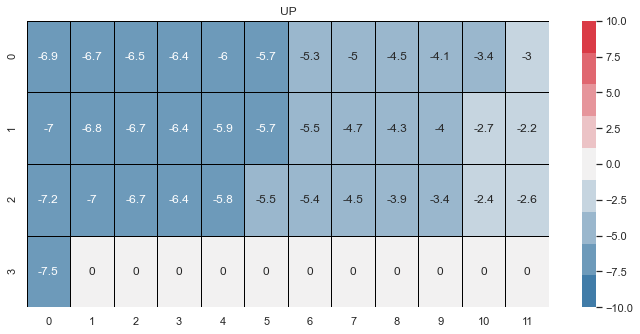

In [22]:
mk_heatmap(q_learner.Q, 0, 'UP')

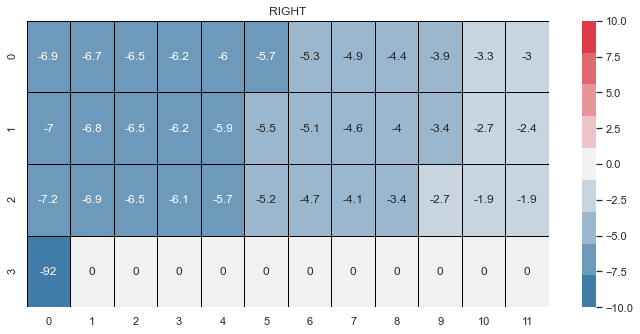

In [23]:
mk_heatmap(q_learner.Q, 1, 'RIGHT')

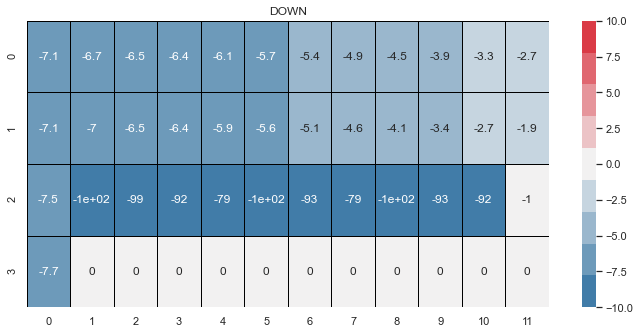

In [24]:
mk_heatmap(q_learner.Q, 2, 'DOWN')

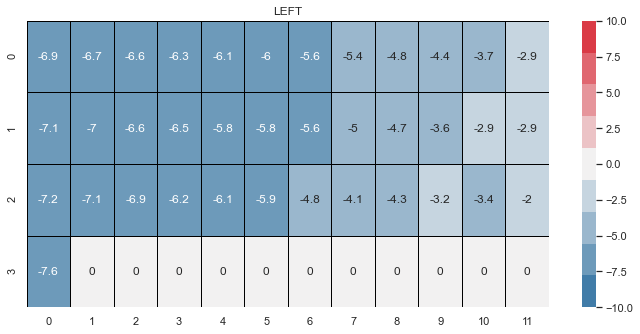

In [25]:
mk_heatmap(q_learner.Q, 3, 'LEFT')

# SARSA

## Pseudo-Code for SARSA Algorithm

![cliffworld](https://drive.google.com/uc?id=1Gcet8XATip6pmJkamO4OKbL1b71I3TfN)

In [26]:
class SARSA(Q_Learning):
  
  def _td_update(self, state, action, env):
    next_state, reward, done, _ = env.step(action)
    
    # Pick the next action
    next_action_probs = self.greedy_pol.get_policy_for_state(state)
    next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)

    td_target = reward + self.df * self.Q[next_state][next_action]
    td_delta = td_target - self.Q[state][action]
    self.Q[state][action] += self.alpha * td_delta
    self.greedy_pol.set_Q(self.Q.copy())
    return done, next_state

In [27]:
env = CliffWalkingEnv()
sarsa_learner = SARSA(num_episodes=500, epsilon = 0.01, verbose=False)
sarsa_learner.train(env)

In [28]:
env.render()
world = np.zeros(env.shape)
for s, v in sarsa_learner.Q.items():
  pos = np.unravel_index(s, env.shape)
  world[pos] = np.argmax(v)
# UP:0, RIGHT: 1, DOWN: 2, LEFT: 3
world

o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T



array([[1., 0., 3., 0., 1., 1., 3., 1., 1., 1., 1., 0.],
       [1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 3., 1.],
       [0., 0., 1., 1., 1., 1., 1., 3., 1., 3., 1., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

# Visualize SARSA Result

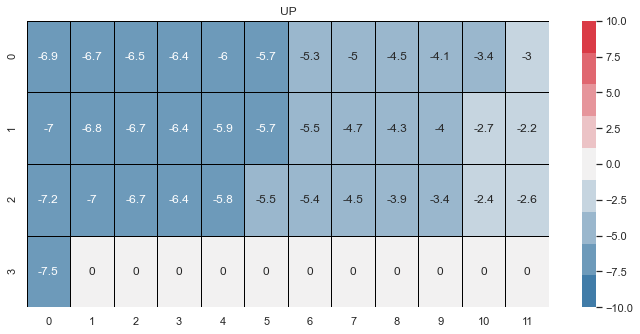

In [29]:
mk_heatmap(sarsa_learner.Q, 0, 'UP')

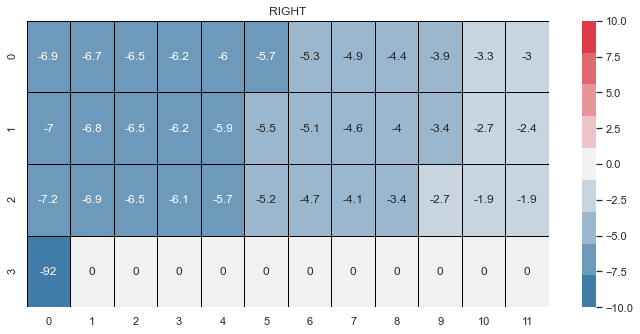

In [30]:
mk_heatmap(sarsa_learner.Q, 1, 'RIGHT')

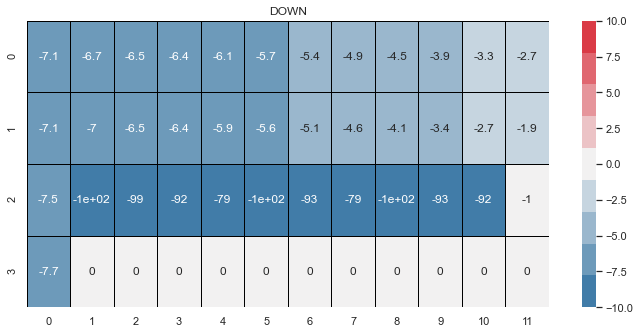

In [31]:
mk_heatmap(sarsa_learner.Q, 2, 'DOWN')

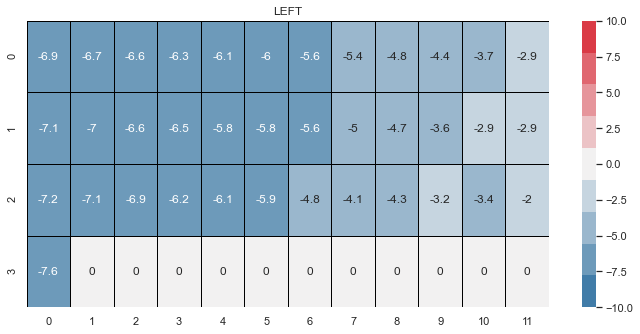

In [32]:
mk_heatmap(sarsa_learner.Q, 3, 'LEFT')

# Exercises

## Implement on-policy MC

Implement the On-policy first-visit MC control method:

![cliffworld](https://drive.google.com/uc?id=16a330_POv-RkJtZilwVXHgmdgvylEENL)


## Mountain car

A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.

### Observational space
Here the core problem is that the observational space is continuous (Note that action space is still discrete).

|   Num   |      Observation       |   Min   |    Max  |
|------|-------------|------|------|
| 0    | position    | -1.2 | 0.6  |
| 1    | velocity    | -0.07| 0.07 |


### Action space

|    Num  |       Observation      |
|------|-------------|
| 0    | push left   |
| 1    | no push     |
| 2    |  push right |


In [33]:
# Example run with random agent
env = utils.wrap_env(gym.make("MountainCar-v0"))
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = env.action_space.sample() 
    observation, reward, done, info = env.step(action) 
    if done: 
      break;
            
env.close()
utils.show_video()